# 1. MODEL TRAINING & SELECTION

In [3]:
import pandas as pd
df=pd.read_csv("Cleaned_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187372 entries, 0 to 187371
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
 13  day_of_week         187372 non-null  int64  
 14  month               187372 non-null  int64  
 15  year                187372 non-nul

In [7]:
pizza_sale=df

**ARIMA / SARIMA ARIMA (AutoRegressive Integrated Moving Average) and 
SARIMA (Seasonal ARIMA) are great starting points for this data shows seasonal patterns and trends.**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
import pickle
import warnings
warnings.filterwarnings("ignore")

## 1.1. ARIMA Model

- p (AutoRegressive term): The number of past observations (lags) used to predict the future value.
- d (Differencing term): The number of times the data is differenced to make it stationary.
- q (Moving Average term): The number of past forecast errors used to improve future predictions.

In [9]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sale)


In [11]:
pizza_sales_weekly

order_date
2014-12-29    2248
2015-01-05    4173
2015-01-12    3567
2015-01-19    3674
2015-01-26    3668
2015-02-02    3824
2015-02-09    3634
2015-02-16    3574
2015-02-23    3989
2015-03-02    3891
2015-03-09    3647
2015-03-16    3697
2015-03-23    3688
2015-03-30    3890
2015-04-06    4215
2015-04-13    3806
2015-04-20    3777
2015-04-27    3531
2015-05-04    2970
2015-05-11    3974
2015-05-18    3692
2015-05-25    3555
2015-06-01    3887
2015-06-08    3690
2015-06-15    3612
2015-06-22    3782
2015-06-29    3578
2015-07-06    3775
2015-07-13    3831
2015-07-20    3766
2015-07-27    3640
2015-08-03    3961
2015-08-10    3592
2015-08-17    3655
2015-08-24    3355
2015-08-31    3630
2015-09-07    3785
2015-09-14    3718
2015-09-21    2601
2015-09-28    3771
2015-10-05    3693
2015-10-12    4095
2015-10-19    3365
2015-10-26    3056
2015-11-02    3878
2015-11-09    3702
2015-11-16    3509
2015-11-23    4597
2015-11-30    3428
2015-12-07    3241
2015-12-14    3729
2015-12-21    2671
2

In [21]:
# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)


Best ARIMA Model MAPE: 0.1976, Best Parameters: (3, 1, 5)
Predictions:
order_date
2015-10-19    3442.390942
2015-10-26    3839.149685
2015-11-02    3632.964303
2015-11-09    3651.363952
2015-11-16    3558.100352
2015-11-23    3872.502659
2015-11-30    3532.646060
2015-12-07    3663.516226
2015-12-14    3652.633656
2015-12-21    3817.589055
2015-12-28    3463.243160
Name: predicted_mean, dtype: float64


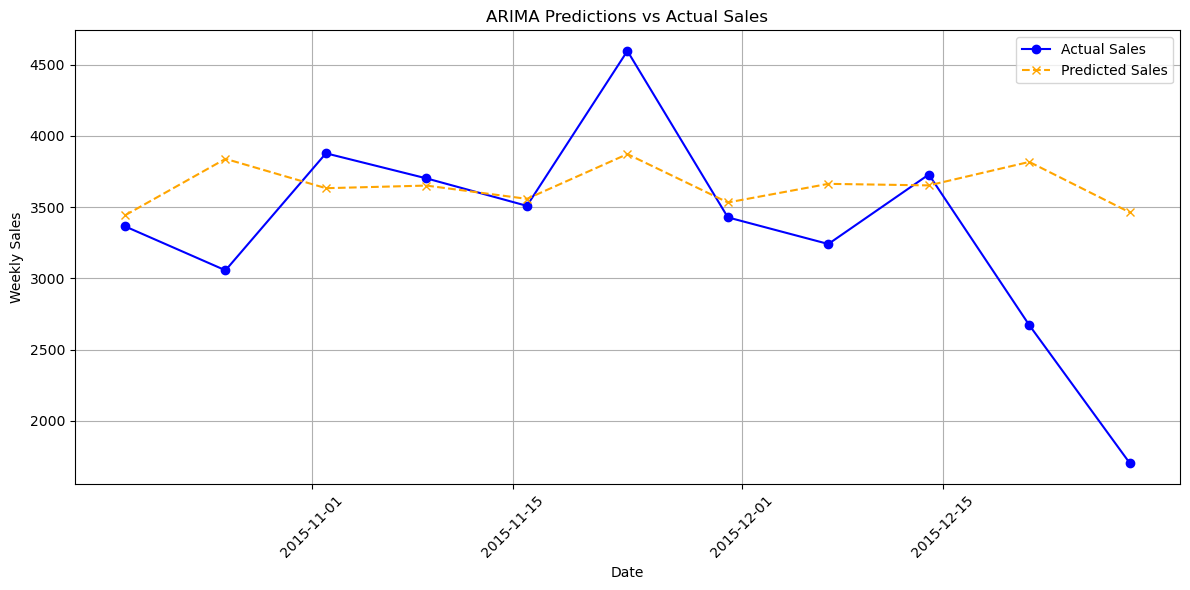

In [23]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 1.2. SARIMA (Seasonal ARIMA)

- P (Seasonal AutoRegressive term): The number of past seasonal values used for prediction.
- D (Seasonal Differencing term): The number of seasonal differencing applied to make data stationary.
- Q (Seasonal Moving Average term): The number of past seasonal forecast errors used for prediction.
- S (Seasonal Period): The length of the seasonal cycle (e.g., 12 for yearly seasonality in monthly data).

In [25]:
# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape


sarima_predictions, sarima_mape_score = best_sarima_model(train, test)
sarima_predictions = pd.Series(sarima_predictions, index=test.index)
print("Predictions:")
print(sarima_predictions)

Best SARIMA Model MAPE: 0.2327
Predictions:
order_date
2015-10-19    3639.064934
2015-10-26    3962.060804
2015-11-02    3803.567948
2015-11-09    3536.255609
2015-11-16    3700.833927
2015-11-23    3810.493781
2015-11-30    3827.372011
2015-12-07    3746.217263
2015-12-14    4015.172822
2015-12-21    3866.686547
2015-12-28    3566.403111
Name: predicted_mean, dtype: float64


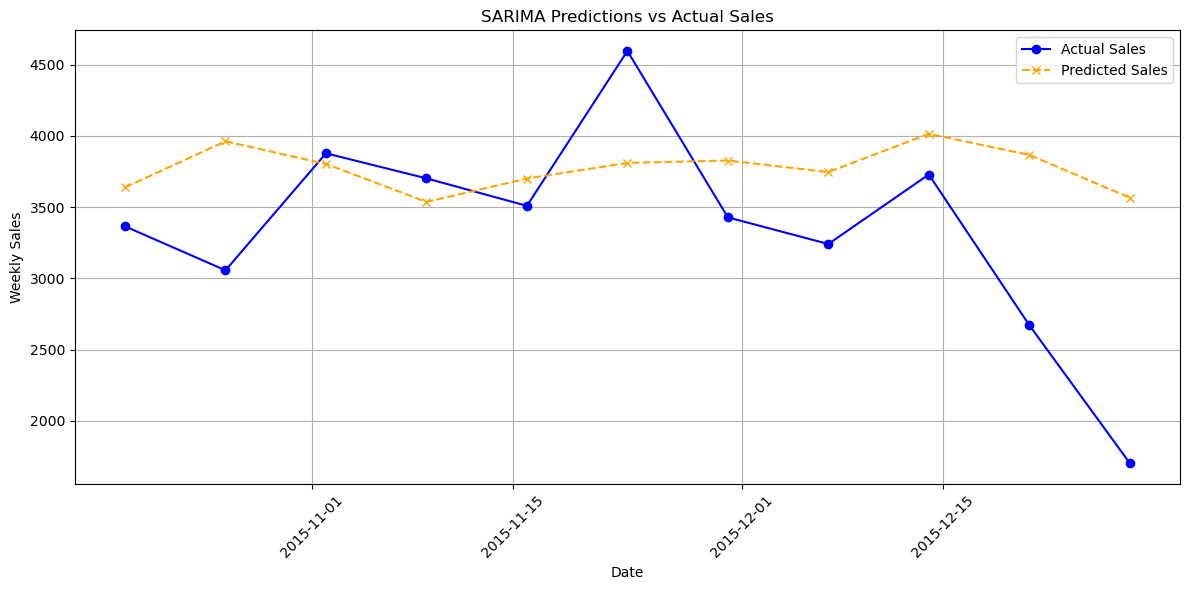

In [27]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 1.3. Prophet (Developed by Facebook)

Prophet is a popular model for handling time series data with seasonal and holiday effects.
The Facebook Prophet model is a tool developed by Facebook for forecasting time series data. It’s especially useful when you want to predict future values based on historical data, such as sales, temperatures, or website traffic.

Growth: Defines the trend type (linear or logistic).
Changepoints: Points where the trend changes.
Seasonality: Models seasonal patterns (weekly, yearly, etc.).
Holidays: Incorporates custom holidays or events affecting the forecast.
Seasonality Mode: Can be additive or multiplicative.

In [29]:
# Pizza sales by week
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # this model requires columns 'ds'- date and 'y'- target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(pizza_sale)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)
    
    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

13:04:50 - cmdstanpy - INFO - Chain [1] start processing
13:04:50 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.2163
Predictions:
ds
2015-10-19    3684.955697
2015-10-26    3685.691317
2015-11-02    3686.426937
2015-11-09    3687.162557
2015-11-16    3687.898177
2015-11-23    3688.633796
2015-11-30    3689.369416
2015-12-07    3690.105036
2015-12-14    3690.840656
2015-12-21    3691.576276
2015-12-28    3692.311896
dtype: float64


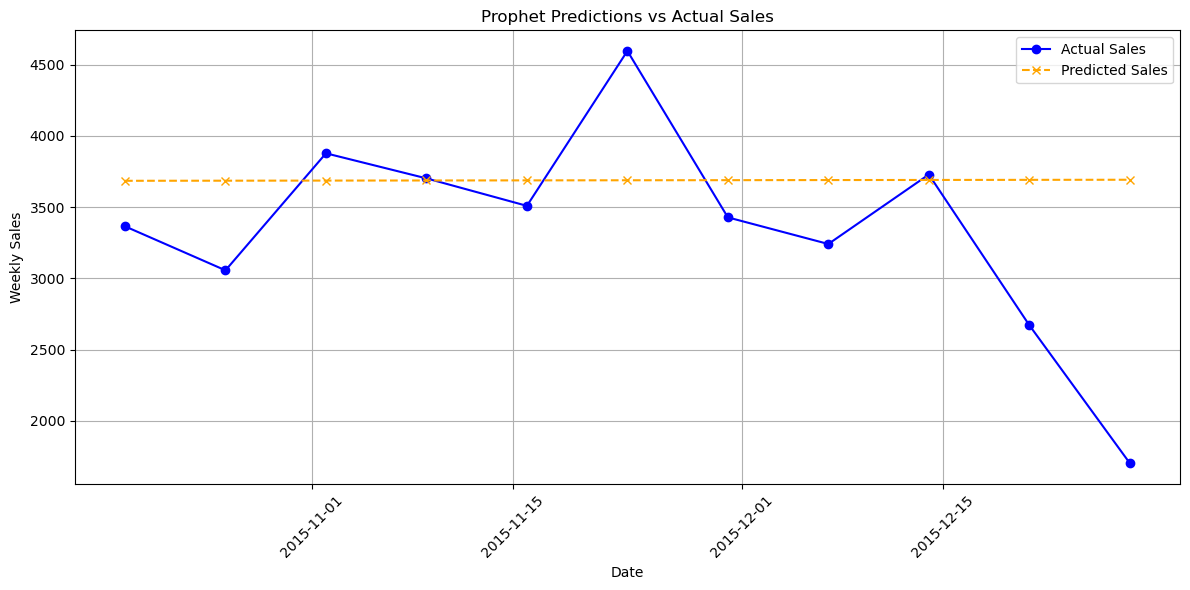

In [31]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 1.4. LSTM model

The **Long Short-Term Memory (LSTM)** model is a type of recurrent neural network (RNN) widely used for time-series forecasting. It is particularly effective for modeling sequences because it can capture long-term dependencies and temporal patterns.

In [33]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sale)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input-Essential for compatibility with LSTM input requirements.
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1)) #Adds a fully connected layer with 1 neuron 
    model.compile(optimizer='adam', loss='mse')#adam- Adaptive optimizer for efficient training.

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions) # normalized minmacscalarm-tranformation
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    
    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Best LSTM Model MAPE: 0.2341
Predictions:
order_date
2015-11-09    3500.137695
2015-11-16    3563.879639
2015-11-23    3691.573730
2015-11-30    3805.964111
2015-12-07    3776.116943
2015-12-14    3773.090332
2015-12-21    3525.517822
2015-12-28    3401.771729
dtype: float32


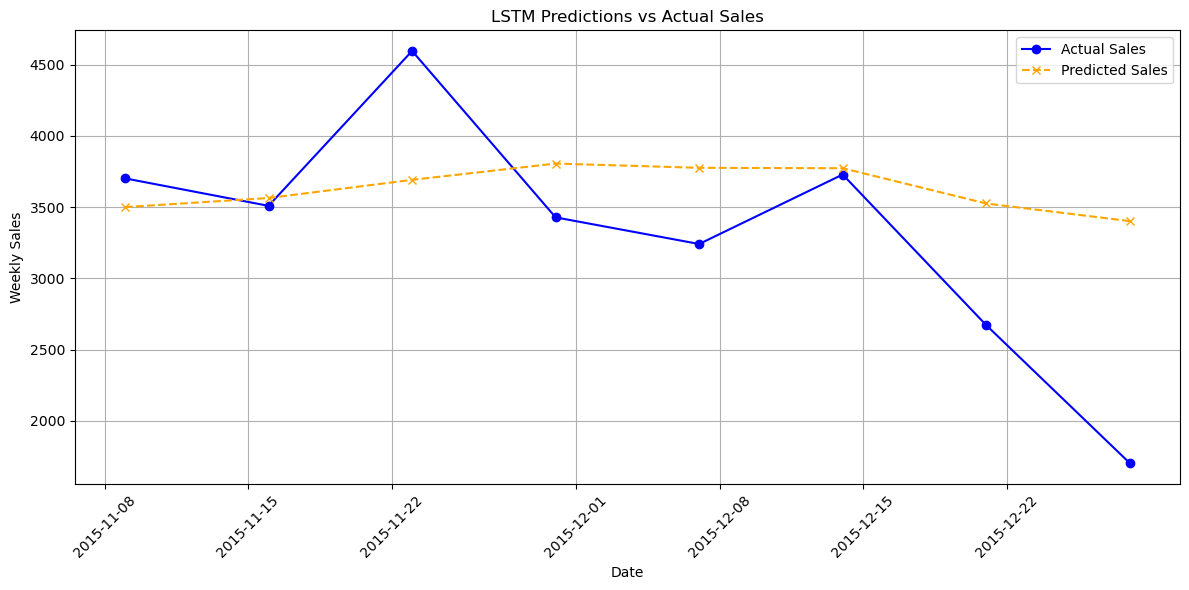

In [35]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 2. FORECASTED SALES FOR THE WEEK

## 2.1. ARIMA Model forecasted sales for the week:

In [13]:
# ARIMA Model forecasted sales for the week:

# Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sale)

# Function to forecast sales for each pizza type using ARIMA
def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    model = ARIMA(train, order=(0, 0, 1))
    model_fit = model.fit()

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using ARIMA
def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using ARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week using ARIMA
next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 90 pizzas
bbq_ckn_m: 91 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 110 pizzas
brie_carre_s: 37 pizzas
calabrese_l: 19 pizzas
calabrese_m: 40 pizzas
cali_ckn_l: 89 pizzas
cali_ckn_m: 95 pizzas
cali_ckn_s: 42 pizzas
ckn_alfredo_l: 17 pizzas
ckn_alfredo_m: 67 pizzas
ckn_alfredo_s: 10 pizzas
ckn_pesto_l: 30 pizzas
ckn_pesto_m: 18 pizzas
ckn_pesto_s: 20 pizzas
classic_dlx_l: 30 pizzas
classic_dlx_m: 67 pizzas
classic_dlx_s: 45 pizzas
five_cheese_l: 54 pizzas
four_cheese_l: 121 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 11 pizzas
green_garden_m: 23 pizzas
green_garden_s: 47 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 27 pizzas
hawaiian_s: 56 pizzas
ital_cpcllo_l: 58 pizzas
ital_cpcllo_m: 27 pizzas
ital_cpcllo_s: 21 pizzas
ital_supr_l: 52 pizzas
ital_supr_m: 69 pizzas
ital_supr_s: 15 pizzas
ital_veggie_m: 37 pizzas
ital_veggie_s: 17 pizzas
mediterraneo_l: 34 pizzas
mediterraneo_m: 27 pizzas
mediterraneo_s: 28 pizzas
mexicana_l:

# 3. MODEL EVALUATION

In [83]:
model_performance = {
    'Model': ['ARIMA', 'SARIMA','Prophet','LSTM'],
    'MAPE': [0.1976, 0.2327,0.2163,0.2341]
}

df_performance = pd.DataFrame(model_performance)

#shwoing which model best
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')
df_performance

,Model,MAPE,Rank,Best/Worst
0,ARIMA,0.1976,1.0,Best
2,Prophet,0.2163,2.0,
1,SARIMA,0.2327,3.0,
3,LSTM,0.2341,4.0,Worst


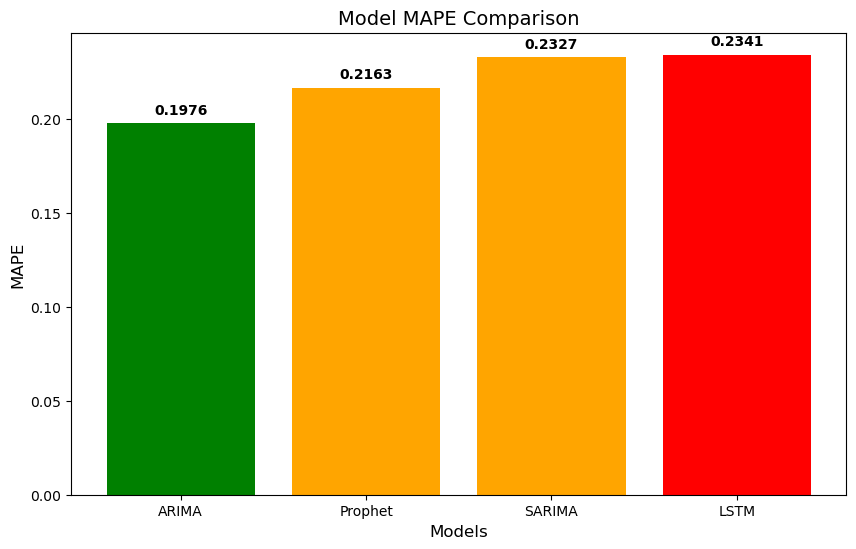

In [93]:
# Visualization and Highlighting the best and worst models
models = ['ARIMA','Prophet','SARIMA', 'LSTM']
mapes = [0.1976,0.2163, 0.2327,0.2341]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green','orange', 'orange','red'])
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center' ,fontweight='bold')

plt.show()

# 4. HYPERPARAMETER OPTIMIZATION FOR THE BEST-PERFORMING ARIMA MODEL

In [101]:
# Ensure order_date is the index
train.set_index('order_date', inplace=True)

# Passing only the 'quantity' column to auto_arima
auto_model = auto_arima(
    train['quantity'],# Providing univariate time series
    seasonal=True, 
    m=7,  # Weekly seasonality
    trace=True, 
    error_action='ignore', #Ignores errors from invalid parameter combinations
    suppress_warnings=True
)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=615.080, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=617.446, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=811.016, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=617.078, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=616.488, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=615.448, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=615.026, Time=0.07 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=616.993, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=617.164, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=617.003, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=619.023, Time=0.13 se

# 5. MODEL SAVING WITH PICKLE

In [55]:
model_filename = 'best_arima_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(auto_model, file)
print(f"Model saved as {model_filename}")


Model saved as best_arima_model.pkl


# 6. FINAL RESULTS & PREDICTION

In [114]:
model_filename = 'best_arima_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Forecasting function to predict weekly sales quantity
def forecast_sales(loaded_model, periods):
    forecast = loaded_model.predict(n_periods=periods)
    return forecast

forecasted_sales = forecast_sales(loaded_model, periods=5)
print(forecasted_sales)

2015-10-19    3557.453133
2015-10-26    3675.142597
2015-11-02    3675.142597
2015-11-09    3675.142597
2015-11-16    3675.142597
Freq: W-MON, dtype: float64


# 7. FORECASTING REPORT VISUALIZATION

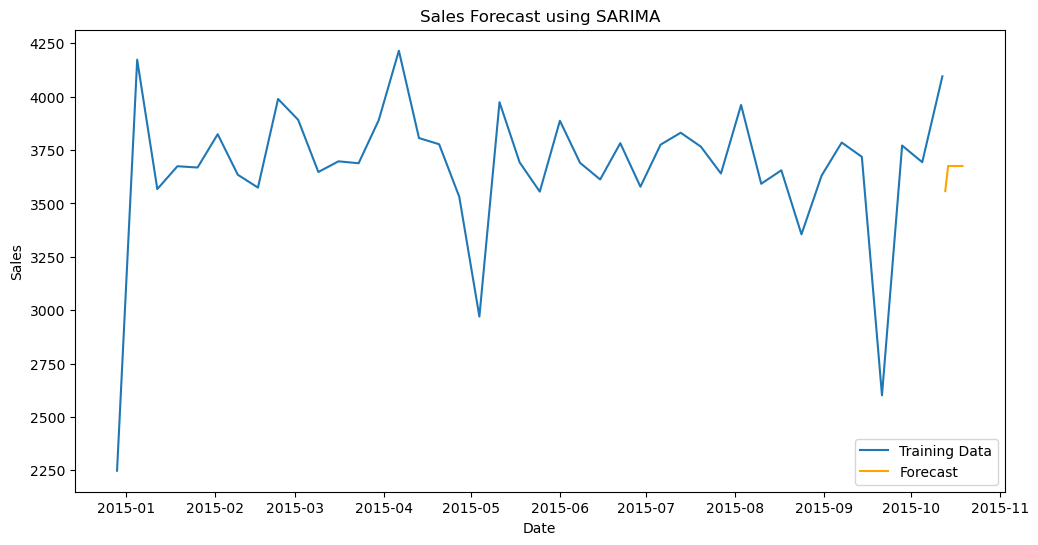

In [127]:
# Loading the best model
with open('best_arima_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Forecasting the data
n_forecast = 7
forecast = best_model.predict(n_periods=n_forecast)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=n_forecast), forecast, label='Forecast', color='orange')
plt.title('Sales Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# 8. PREDICTED INGREDIENT QUANTITY CALCULATION AND DISPLAY

## 8.1. Ingredient Quantity Calculation

In [133]:
Ingredients_dataset=pd.read_excel('Pizza_ingredients.xlsx')

In [142]:
# Copy ingredients, map predicted sales, and calculateing the total ingredient quantity
ingredients_predicted = Ingredients_dataset.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_arima)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']
ingredients_predicted.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,90,3600.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,90,1350.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,90,1800.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,90,2700.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,90,5400.0


In [139]:
# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
ingredient_totals

Total quantity of predicted ingredients for the following week:


{'?duja Salami': 2900.0,
 'Alfredo Sauce': 1445.0,
 'Anchovies': 3345.0,
 'Artichokes': 11125.0,
 'Arugula': 700.0,
 'Asiago Cheese': 6410.0,
 'Bacon': 29050.0,
 'Barbecue Sauce': 2395.0,
 'Barbecued Chicken': 6870.0,
 'Beef Chuck Roast': 13170.0,
 'Blue Cheese': 1620.0,
 'Brie Carre Cheese': 1110.0,
 'Calabrese Salami': 15450.0,
 'Capocollo': 62650.0,
 'Caramelized Onions': 0.0,
 'Chicken': 85750.0,
 'Chipotle Sauce': 7330.0,
 'Chorizo Sausage': 5500.0,
 'Cilantro': 3665.0,
 'Coarse Sicilian Salami': 11280.0,
 'Corn': 24590.0,
 'Eggplant': 2660.0,
 'Feta Cheese': 10880.0,
 'Fontina Cheese': 6570.0,
 'Friggitello Peppers': 725.0,
 'Garlic': 24740.0,
 'Genoa Salami': 8460.0,
 'Goat Cheese': 13240.0,
 'Gorgonzola Piccante Cheese': 5720.0,
 'Gouda Cheese': 4990.0,
 'Green Olives': 4775.0,
 'Green Peppers': 6990.0,
 'Italian Sausage': 1100.0,
 'Jalapeno Peppers': 6160.0,
 'Kalamata Olives': 3510.0,
 'Luganega Sausage': 5640.0,
 'Mozzarella Cheese': 11870.0,
 'Mushrooms': 26880.0,
 'Onions'

In [144]:
# dict into a Pandas DataFrame
ingredient_df = pd.DataFrame(list(ingredient_totals.items()), columns=['Ingredient', 'Total Quantity (grams)'])


In [146]:
ingredient_df

,Ingredient,Total Quantity (grams)
0,?duja Salami,2900.0
1,Alfredo Sauce,1445.0
2,Anchovies,3345.0
3,Artichokes,11125.0
4,Arugula,700.0
...,...,...
59,Sun-dried Tomatoes,1590.0
60,Thai Sweet Chilli Sauce,4230.0
61,Thyme,185.0
62,Tomatoes,49090.0


## 8.2. Visualizing the Total Tuantities of Ingredients with Data Points

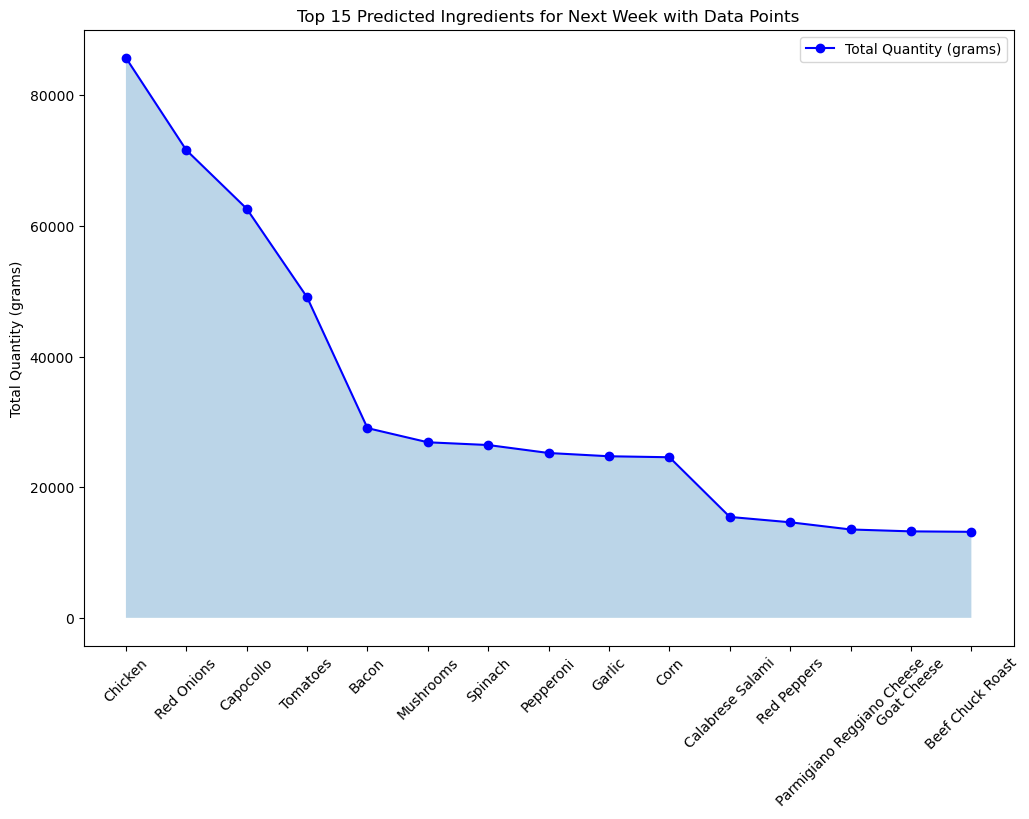

In [148]:
plt.figure(figsize=(12, 8))
top_ingredients = ingredient_df.nlargest(15, 'Total Quantity (grams)')

# Plotting with data points
plt.plot(top_ingredients['Ingredient'], top_ingredients['Total Quantity (grams)'], marker='o', color='b', linestyle='-', label='Total Quantity (grams)')
plt.fill_between(top_ingredients['Ingredient'], top_ingredients['Total Quantity (grams)'], alpha=0.3)
plt.title('Top 15 Predicted Ingredients for Next Week with Data Points')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


## 8.3. Saving the Ingredients Total to a DF

In [73]:
ingredient_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


In [75]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,2900.0
1,Alfredo Sauce,1445.0
2,Anchovies,3345.0
3,Artichokes,11125.0
4,Arugula,700.0
...,...,...
59,Sun-dried Tomatoes,1590.0
60,Thai Sweet Chilli Sauce,4230.0
61,Thyme,185.0
62,Tomatoes,49090.0
